## 01-Importação das Bibliotecas

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

## 02-Base de Dados

### 02.1-Base de dados para previsor

In [190]:
base_vli = pd.read_excel('/VLI/Projeto/base_nova/Relatório Despesas Cartões Corporativos22.xlsx', sheet_name = 'Main Page_1')
new_header = base_vli.iloc[4]
new_header.reset_index()
base_vli.columns = new_header
base_vli = base_vli[5:]
base_vli = base_vli.reset_index()
columns = ['index','Tipo de Pagamento', 'Último Segmento do Cartão','Número da Conta', 'Nome',
           'Moeda da Transação',
       'Valor da Transação (Moeda de Reembolso)', 'Moeda de Reembolso',
       'Data da Transação', 'Data do Faturamento', 'Data da Carga',
       'Número de Referência', 'ID do Relatório de Despesas', 'Status']
base_vli.drop(columns, inplace=True, axis=1)
df1 = base_vli.groupby(['Matrícula','Fornecedor','Empresa'])['Valor da Transação'].sum()
df1 = pd.DataFrame(df1)
df1 = df1.add_suffix('').reset_index()
df_empregados = pd.read_excel('/VLI/Projeto/base_nova/01 - QL Setembro.xlsx', sheet_name = 'Consolidado QL Setembro')
columns = ['EMPRESA','FORÇA DE TRABALHO', 'PCD', 'MATRICULA', 'NOME',
       'DATA ADM', 'POSICAO', 'DESC POSICAO', 'CARGO', 'DESC CARGO', 'C CUSTO',
       'NOME CC', 'DIRETORIA CC', 'GERENCIA GERAL CC', 'GERENCIA CC',
       'SUPERVISAO CC', '"ID GESTOR', 'NOME GESTOR', 'Classific. Custos',
       'GH', 'DESC GH', 'LOTACAO', 'DESC LOT', 'MUNIC ESTABEL',
       'ESTABELECIMENTO', 'NOME ESTABELECIMENTO',
       'UF ESTABELEC', 'UF LOCAL TRAB',
       '"DESCR. CONTRATO TRABALHO', 'DT VENC CONTRATO', 'JORNADA SEMANAL',
       '"DT NASC', 'GRUPO ETNICO', '% PERIC', '% INSALUBR', '"ESTABILIDADE',
       'INICIO ESTAB', 'FIM ESTAB', 'QTD DIAS ESTAB', '"MOTIVO AFAST',
       'INICIO AFAST', 'FIM AFAST', '"GH NV 7', 'NOME GH NV 7', 'GH NV 6',
       'NOME GH NV 6', 'GH NV 5', 'NOME GH NV 5', 'GH NV 4', 'NOME GH NV 4',
       'GH NV 3', 'NOME GH NV 3', 'GH NV 2', 'NOME GH NV 2', 'GH NV 1',
       'NOME GH NV 1']
df_empregados.drop(columns, inplace=True, axis=1)
df_empregados = df_empregados.rename(columns={'ID': 'Matrícula', })   
base_vli['Matrícula'] = base_vli['Matrícula'].astype('int64')
df = base_vli.merge(df_empregados, on='Matrícula', how='left')
df = df.rename(columns={'Empresa': 'EMPRESA', 'Valor da Transação':'VALOR_CARTAO',
                        'NAT PROFIS (FUNCAO)':'Cargo', 'MUNIC LOCAL TRAB':'Localidade'}) 
df = pd.DataFrame(df)
columns = ['Matrícula', 'Fornecedor']
df.drop(columns, inplace=True, axis=1)
df = df.drop(df[df.Localidade == 'LEOPOLDO DE BULHOES'].index)
df = df.drop(df[df.Localidade == 'MAIRINQUE'].index)
df = df.drop(df[df.Localidade == 'PORTO NACIONAL'].index)
df = df.drop(df[df.Localidade == 'RIO DE JANEIRO'].index)
df = df.drop(df[df.Localidade == 'SALVADOR'].index)
a = {'ADMINISTRATIVO / OPERACIONAL':'ADMINISTRATIVO / OPERACIONAL','ESPECIALISTA':'L2 - GERÊNCIA / COORDENAÇÃO',
     'L1 - SUPERVISOR':'L1 - SUPERVISOR','L2 - GERÊNCIA / COORDENAÇÃO':'L2 - GERÊNCIA / COORDENAÇÃO', 'L3 - GER.GERAL./ COORD.EXEC':'L2 - GERÊNCIA / COORDENAÇÃO',
    'L4 - DIR.DEPTO/COORDADMSUP':'L2 - GERÊNCIA / COORDENAÇÃO', 'L5 - DIRETORIA':'L2 - GERÊNCIA / COORDENAÇÃO',
    'L7 - PRESIDÊNCIA':'L2 - GERÊNCIA / COORDENAÇÃO','NIVEL TECNICO':'NIVEL TECNICO',
     'TECNICO PROFISSIONAL':'TECNICO PROFISSIONAL','TT - CARREIRA TECNICA':'TT - CARREIRA TECNICA',
     'TS - CARREIRA TECNICA':'TT - CARREIRA TECNICA'}
df['Cargo'] = df['Cargo'].map(a)
df = df[df['SEXO'].notnull()]
b = {'Ferrovia Centro Atlântica':'Ferrovia Centro Atlântica','VLI Multimodal':'VLI Multimodal',
    'Ferrovia Norte Sul':'Ferrovia Norte Sul','UltraFertil':'UltraFertil', 'VLI':'VLI Multimodal'}
df['EMPRESA'] = df['EMPRESA'].map(b)
previsores = df.iloc[:, 0:5].values
onehotencoder = ColumnTransformer(transformers = [("OneHot", OneHotEncoder(),
                                                   [0,2,3,4])], 
                                  remainder = 'passthrough')
previsores = onehotencoder.fit_transform(previsores).toarray()

### 02.2-Base de dados para treino

In [193]:
np.random.seed(123)
torch.manual_seed(123)
base = pd.read_excel('/VLI/Projeto/Base_py_v03.xlsx', sheet_name = 'Sheet1')
columns = ['MATR_EMPREGADO', 'NOME GH NV 5', 'Diretoria']
base.drop(columns, inplace=True, axis=1)
base = base.drop(base[base.Localidade == 'BRASILIA'].index)
previsores = base.iloc[:, 0:5].values
classe = base.iloc[:, 5].values
onehotencoder = ColumnTransformer(transformers = [("OneHot", OneHotEncoder(),
                                                   [0,2,3,4])], 
                                  remainder = 'passthrough')
previsores = onehotencoder.fit_transform(previsores).toarray()

## Construção do modelo

In [194]:
class classificador_torch(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense0 = nn.Linear(61, 62)
        torch.nn.init.normal_(self.dense0.weight, mean = 0.0, std= 0.05)
        self.activation0 = torch.tanh
        self.Dropout0 = nn.Dropout(0.3)       
        self.dense1 = nn.Linear(62, 62)
        torch.nn.init.normal_(self.dense1.weight, mean = 0.0, std= 0.05)
        self.activation1 = torch.tanh
        self.Dropout1 = nn.Dropout(0.3)
        self.dense2 = nn.Linear(62, 31)
        torch.nn.init.normal_(self.dense2.weight, mean = 0.0, std= 0.05)
        self.activation2 = torch.tanh
        self.Dropout2 = nn.Dropout(0.3)      
        self.dense3 = nn.Linear(31, 15)
        torch.nn.init.normal_(self.dense3.weight, mean = 0.0, std= 0.05)
        self.activation3 = torch.tanh
        self.Dropout3 = nn.Dropout(0.3)      
        self.dense4 = nn.Linear(15, 31)
        torch.nn.init.normal_(self.dense4.weight, mean = 0.0, std= 0.05)
        self.activation4 = torch.tanh
        self.Dropout4 = nn.Dropout(0.3)
        self.dense5 = nn.Linear(31, 62)
        torch.nn.init.normal_(self.dense5.weight, mean = 0.0, std= 0.05)
        self.activation5 = torch.tanh
        self.Dropout5 = nn.Dropout(0.3)     
        self.dense6 = nn.Linear(62, 1)
        torch.nn.init.normal_(self.dense6.weight, mean = 0.0, std= 0.05)
        self.activation6 = nn.Sigmoid()
    def forward(self, X):
        X = self.dense0(X)
        X = self.activation0(X)
        X = self.Dropout0(X) 
        X = self.dense1(X)
        X = self.activation1(X)
        X = self.Dropout1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        X = self.Dropout2(X)
        X = self.dense3(X)
        X = self.activation3(X)
        X = self.Dropout3(X)     
        X = self.dense4(X)
        X = self.activation4(X)
        X = self.Dropout4(X)                
        X = self.dense5(X)
        X = self.activation5(X)
        X = self.Dropout5(X)
        X = self.dense6(X)
        X = self.activation6(X)
        return X

In [195]:
classificador = classificador_torch()

In [196]:
criterion = nn.MSELoss()
optimizer = optim.Adam(classificador.parameters())

In [197]:
previsores = torch.tensor(previsores, dtype=torch.float)
classe = torch.tensor(classe, dtype=torch.float)

In [423]:
dataset = torch.utils.data.TensorDataset(previsores, classe)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 2300, shuffle = False)

## Treinamento do modelo

In [424]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [425]:
classificador.to(device)

classificador_torch(
  (dense0): Linear(in_features=61, out_features=62, bias=True)
  (Dropout0): Dropout(p=0.3, inplace=False)
  (dense1): Linear(in_features=62, out_features=62, bias=True)
  (Dropout1): Dropout(p=0.3, inplace=False)
  (dense2): Linear(in_features=62, out_features=31, bias=True)
  (Dropout2): Dropout(p=0.3, inplace=False)
  (dense3): Linear(in_features=31, out_features=15, bias=True)
  (Dropout3): Dropout(p=0.3, inplace=False)
  (dense4): Linear(in_features=15, out_features=31, bias=True)
  (Dropout4): Dropout(p=0.3, inplace=False)
  (dense5): Linear(in_features=31, out_features=62, bias=True)
  (Dropout5): Dropout(p=0.3, inplace=False)
  (dense6): Linear(in_features=62, out_features=1, bias=True)
  (activation6): Sigmoid()
)

In [426]:
for epoch in range(200): # testado com 4000 achados 82 indicios, 8000 achados 88 indicios
    running_loss = 0.
    running_mse = 0.
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = classificador.forward(inputs)
        
        mse =  F.mse_loss(outputs, labels.unsqueeze(1)).item()
        running_mse += mse * len(inputs)
        
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        loss = loss.item()
        running_loss += loss * len(inputs)
       
        print('\rÉpoca {:4d} - Loop {:3d} de {:3d}: erro {:6.4f} - custo {:6.4f}'.format(epoch + 1,
                      i + 1,
                      len(train_loader),
                      mse,
                      loss), end = '\r')

    print('ÉPOCA {:4d} finalizada: erro {:6.4f} - custo {:6.4f}         '.format(epoch + 1, 
         running_mse/len(dataset),  
         running_loss/len(dataset)))

ÉPOCA    1 finalizada: erro 0.0179 - custo 0.0179         
ÉPOCA    2 finalizada: erro 0.0177 - custo 0.0177         
ÉPOCA    3 finalizada: erro 0.0171 - custo 0.0171         
ÉPOCA    4 finalizada: erro 0.0172 - custo 0.0172         
ÉPOCA    5 finalizada: erro 0.0173 - custo 0.0173         
ÉPOCA    6 finalizada: erro 0.0170 - custo 0.0170         
ÉPOCA    7 finalizada: erro 0.0171 - custo 0.0171         
ÉPOCA    8 finalizada: erro 0.0170 - custo 0.0170         
ÉPOCA    9 finalizada: erro 0.0171 - custo 0.0171         
ÉPOCA   10 finalizada: erro 0.0174 - custo 0.0174         
ÉPOCA   11 finalizada: erro 0.0173 - custo 0.0173         
ÉPOCA   12 finalizada: erro 0.0179 - custo 0.0179         
ÉPOCA   13 finalizada: erro 0.0184 - custo 0.0184         
ÉPOCA   14 finalizada: erro 0.0184 - custo 0.0184         
ÉPOCA   15 finalizada: erro 0.0188 - custo 0.0188         
ÉPOCA   16 finalizada: erro 0.0179 - custo 0.0179         
ÉPOCA   17 finalizada: erro 0.0186 - custo 0.0186       

ÉPOCA  139 finalizada: erro 0.0157 - custo 0.0157         
ÉPOCA  140 finalizada: erro 0.0155 - custo 0.0155         
ÉPOCA  141 finalizada: erro 0.0156 - custo 0.0156         
ÉPOCA  142 finalizada: erro 0.0156 - custo 0.0156         
ÉPOCA  143 finalizada: erro 0.0155 - custo 0.0155         
ÉPOCA  144 finalizada: erro 0.0157 - custo 0.0157         
ÉPOCA  145 finalizada: erro 0.0155 - custo 0.0155         
ÉPOCA  146 finalizada: erro 0.0153 - custo 0.0153         
ÉPOCA  147 finalizada: erro 0.0159 - custo 0.0159         
ÉPOCA  148 finalizada: erro 0.0160 - custo 0.0160         
ÉPOCA  149 finalizada: erro 0.0166 - custo 0.0166         
ÉPOCA  150 finalizada: erro 0.0161 - custo 0.0161         
ÉPOCA  151 finalizada: erro 0.0170 - custo 0.0170         
ÉPOCA  152 finalizada: erro 0.0157 - custo 0.0157         
ÉPOCA  153 finalizada: erro 0.0161 - custo 0.0161         
ÉPOCA  154 finalizada: erro 0.0156 - custo 0.0156         
ÉPOCA  155 finalizada: erro 0.0161 - custo 0.0161       

In [427]:
classificador.eval()

classificador_torch(
  (dense0): Linear(in_features=61, out_features=62, bias=True)
  (Dropout0): Dropout(p=0.3, inplace=False)
  (dense1): Linear(in_features=62, out_features=62, bias=True)
  (Dropout1): Dropout(p=0.3, inplace=False)
  (dense2): Linear(in_features=62, out_features=31, bias=True)
  (Dropout2): Dropout(p=0.3, inplace=False)
  (dense3): Linear(in_features=31, out_features=15, bias=True)
  (Dropout3): Dropout(p=0.3, inplace=False)
  (dense4): Linear(in_features=15, out_features=31, bias=True)
  (Dropout4): Dropout(p=0.3, inplace=False)
  (dense5): Linear(in_features=31, out_features=62, bias=True)
  (Dropout5): Dropout(p=0.3, inplace=False)
  (dense6): Linear(in_features=62, out_features=1, bias=True)
  (activation6): Sigmoid()
)

In [428]:
previsores = previsores.to(device)
previsoes = classificador.forward(previsores)

In [429]:
previsoes = previsoes.cpu().detach().numpy()

In [430]:
previsoes.mean(axis = 0)

array([0.02940197], dtype=float32)

In [431]:
classe.mean(axis = 0)

tensor(0.0271)

Text(0.5, 1.0, 'Indicio')

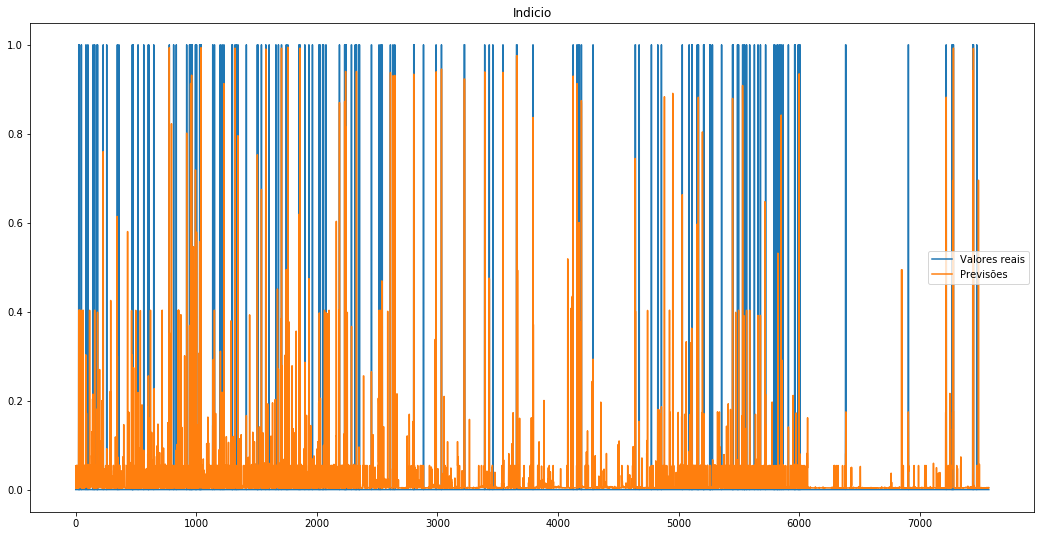

In [432]:
fig, ax = plt.subplots(1, 1, figsize=(18,9))
ax.plot(classe[:])
ax.plot(previsoes[:])
ax.legend(['Valores reais', 'Previsões'])
ax.set_title(base.columns[5])

In [433]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [434]:
import seaborn as sns

In [435]:
previsoes = np.array(previsoes > 0.5)
previsoes

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [436]:
matriz = confusion_matrix(classe, previsoes)
matriz

array([[7356,   12],
       [ 132,   73]], dtype=int64)

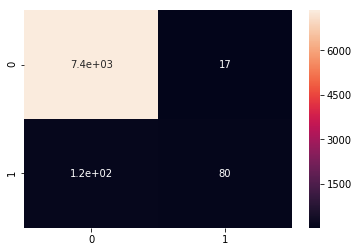

In [370]:
sns.heatmap(matriz, annot=True);

# Salvar o classificador

In [371]:
classificador.state_dict()

OrderedDict([('dense0.weight',
              tensor([[-0.6922, -0.5536, -0.8872,  ..., -0.8900, -1.0657,  0.0315],
                      [ 0.3698, -0.7207, -1.8184,  ...,  0.9640, -0.7599,  0.0196],
                      [ 0.1708,  0.3220, -0.2434,  ...,  0.3745,  0.3521,  0.0540],
                      ...,
                      [ 0.2839,  0.0203,  0.2061,  ...,  0.2985,  0.3409,  0.1020],
                      [ 0.1802,  0.3146, -1.5327,  ...,  0.6309, -1.5903, -0.0148],
                      [-0.3592, -0.4877,  1.1937,  ..., -0.6186, -0.2249,  0.0282]])),
             ('dense0.bias',
              tensor([-0.8827, -0.1979,  0.2798, -0.8947,  0.4550, -0.7666, -1.0239,  0.4550,
                       0.5263, -0.5225,  0.0355,  0.9717,  0.6761, -0.6444, -0.7256,  0.8178,
                       0.8082,  0.0192,  0.6330, -1.0325,  0.5921, -0.8731,  0.2530,  0.7747,
                      -0.7848,  0.5176, -0.5615,  0.5941, -0.4274, -0.5905, -0.2891, -0.0172,
                       0.4437,

In [372]:
torch.save(classificador.state_dict(), 'checkpoint.pth')

# Carregar o Classificador

In [120]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [121]:
np.random.seed(123)
torch.manual_seed(123)

In [122]:
class classificador_torch(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense0 = nn.Linear(61, 62)
        torch.nn.init.normal_(self.dense0.weight, mean = 0.0, std= 0.05)
        self.activation0 = torch.tanh
        self.Dropout0 = nn.Dropout(0.2)
        
        self.dense1 = nn.Linear(62, 62)
        torch.nn.init.normal_(self.dense1.weight, mean = 0.0, std= 0.05)
        self.activation1 = torch.tanh
        self.Dropout1 = nn.Dropout(0.2)

        self.dense2 = nn.Linear(62, 31)
        torch.nn.init.normal_(self.dense2.weight, mean = 0.0, std= 0.05)
        self.activation2 = torch.tanh
        self.Dropout2 = nn.Dropout(0.2)

        self.dense3 = nn.Linear(31, 62)
        torch.nn.init.normal_(self.dense3.weight, mean = 0.0, std= 0.05)
        self.activation3 = torch.tanh
        self.Dropout3 = nn.Dropout(0.2)
        
        self.dense4 = nn.Linear(62, 1)
        torch.nn.init.normal_(self.dense4.weight, mean = 0.0, std= 0.05)
        self.activation4 = nn.Sigmoid()
    def forward(self, X):
        X = self.dense0(X)
        X = self.activation0(X)
        X = self.Dropout0(X) 
        X = self.dense1(X)
        X = self.activation1(X)
        X = self.Dropout1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        X = self.Dropout2(X)
        X = self.dense3(X)
        X = self.activation3(X)
        X = self.Dropout3(X)
        X = self.dense4(X)
        X = self.activation4(X)
        return X

In [123]:
classificador = classificador_torch()

In [124]:
state_dict = torch.load('checkpoint.pth')

In [125]:
classificador.load_state_dict(state_dict)

<All keys matched successfully>

## Classifica

In [148]:
previsores.shape

(21160, 61)

In [191]:
type(previsores)

numpy.ndarray

In [150]:
previsores = torch.tensor(previsores, dtype=torch.float)

In [187]:
lista = []
for i in range(len(previsores)):
    novo = previsores[i]
    classificador.eval()
    previsao = classificador(novo)
    previsao = (previsao.detach().numpy() > 0.5)
    previsao = str(previsao.tolist())
    if previsao == '[False]':
        previsao = 0
    else:
        previsao = 1
    lista.append(previsao)
#    print(previsao)

In [189]:
lista.index(1)

612